Project: /overview/_project.yaml
Book: /overview/_book.yaml

<link rel="stylesheet" href="/site-assets/css/style.css">

<!-- DO NOT EDIT! Automatically generated file. -->


{% comment %}
The source of truth file can be found [here]: http://google3/zz
{% endcomment %}

<div itemscope itemtype="http://developers.google.com/ReferenceObject">
<meta itemprop="name" content="RNN を使ったテキスト分類" />
<meta itemprop="path" content="Guide & Tutorials" />
<meta itemprop="property" content="tf.cast"/>
<meta itemprop="property" content="tf.expand_dims"/>
<meta itemprop="property" content="tf.keras.Sequential"/>
<meta itemprop="property" content="tf.keras.layers.Bidirectional"/>
<meta itemprop="property" content="tf.keras.layers.Dense"/>
<meta itemprop="property" content="tf.keras.layers.Dropout"/>
<meta itemprop="property" content="tf.keras.layers.Embedding"/>
<meta itemprop="property" content="tf.keras.layers.LSTM"/>
<meta itemprop="property" content="tf.keras.losses.BinaryCrossentropy"/>
<meta itemprop="property" content="tf.keras.optimizers.Adam"/>
</div>

# RNN を使ったテキスト分類

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

このテキスト分類チュートリアルでは、感情分析のために [IMDB 映画レビュー大型データセット](http://ai.stanford.edu/~amaas/data/sentiment/) を使って [リカレントニューラルネットワーク](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) を訓練します。

## 設定

In [2]:
!pip install tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

2022-12-14 23:30:29.636980: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


`matplotlib` をインポートしグラフを描画するためのヘルパー関数を作成します。

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 入力パイプラインの設定

IMDB 映画レビュー大型データセットは*二値分類*データセットです。すべてのレビューは、*好意的(positive)* または *非好意的(negative)* のいずれかの感情を含んでいます。

[TFDS](https://www.tensorflow.org/datasets) を使ってこのデータセットをダウンロードします。

In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

 このデータセットの `info` には、エンコーダー(`tfds.features.text.SubwordTextEncoder`) が含まれています。

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


このテキストエンコーダーは、任意の文字列を可逆的にエンコードします。必要であればバイトエンコーディングにフォールバックします。

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## 訓練用データの準備

次に、これらのエンコード済み文字列をバッチ化します。`padded_batch` メソッドを使ってバッチ中の一番長い文字列の長さにゼロパディングを行います。

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

Note: **TensorFlow 2.2** から、padded_shapes は必須ではなくなりました。デフォルトではすべての軸をバッチ中で最も長いものに合わせてパディングします。

In [12]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## モデルの作成

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential"><code>tf.keras.Sequential</code></a> モデルを構築しましょう。最初に Embedding レイヤーから始めます。Embedding レイヤーは単語一つに対して一つのベクトルを収容します。呼び出しを受けると、Embedding レイヤーは単語のインデックスのシーケンスを、ベクトルのシーケンスに変換します。これらのベクトルは訓練可能です。（十分なデータで）訓練されたあとは、おなじような意味をもつ単語は、しばしばおなじようなベクトルになります。

このインデックス参照は、ワンホットベクトルを <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense"><code>tf.keras.layers.Dense</code></a> レイヤーを使って行うおなじような演算に比べてずっと効率的です。

リカレントニューラルネットワーク（RNN）は、シーケンスの入力を要素を一つずつ扱うことで処理します。RNN は、あるタイムステップでの出力を次のタイムステップの入力へと、次々に渡していきます。

RNN レイヤーとともに、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional"><code>tf.keras.layers.Bidirectional</code></a> ラッパーを使用することができます。このラッパーは、入力を RNN 層の順方向と逆方向に伝え、その後出力を結合します。これにより、RNN は長期的な依存関係を学習できます。

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

訓練プロセスを定義するため、Keras モデルをコンパイルします。

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## モデルの訓練

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


391/391 [==============================] - 95s 231ms/step - loss: 0.6377 - accuracy: 0.5728 - val_loss: 0.4529 - val_accuracy: 0.7719


Epoch 2/10


391/391 [==============================] - 73s 186ms/step - loss: 0.3278 - accuracy: 0.8643 - val_loss: 0.3480 - val_accuracy: 0.8438


Epoch 3/10


391/391 [==============================] - 63s 160ms/step - loss: 0.2456 - accuracy: 0.9049 - val_loss: 0.3427 - val_accuracy: 0.8724


Epoch 4/10


391/391 [==============================] - 55s 139ms/step - loss: 0.2070 - accuracy: 0.9240 - val_loss: 0.3599 - val_accuracy: 0.8703


Epoch 5/10


391/391 [==============================] - 54s 136ms/step - loss: 0.1807 - accuracy: 0.9339 - val_loss: 0.3375 - val_accuracy: 0.8604


Epoch 6/10


391/391 [==============================] - 50s 126ms/step - loss: 0.1589 - accuracy: 0.9434 - val_loss: 0.3482 - val_accuracy: 0.8604


Epoch 7/10


391/391 [==============================] - 49s 124ms/step - loss: 0.1411 - accuracy: 0.9514 - val_loss: 0.3726 - val_accuracy: 0.8568


Epoch 8/10


391/391 [==============================] - 49s 123ms/step - loss: 0.1279 - accuracy: 0.9566 - val_loss: 0.4189 - val_accuracy: 0.8635


Epoch 9/10


391/391 [==============================] - 45s 115ms/step - loss: 0.1216 - accuracy: 0.9580 - val_loss: 0.5034 - val_accuracy: 0.8500


Epoch 10/10


391/391 [==============================] - 45s 113ms/step - loss: 0.1133 - accuracy: 0.9625 - val_loss: 0.4414 - val_accuracy: 0.8448


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 16s 41ms/step - loss: 0.4472 - accuracy: 0.8446


Test Loss: 0.4472350776195526
Test Accuracy: 0.8445600271224976


上記のモデルはシーケンスに適用されたパディングをマスクしていません。パディングされたシーケンスで訓練を行い、パディングをしていないシーケンスでテストするとすれば、このことが結果を歪める可能性があります。理想的にはこれを避けるために、 [マスキング](../../guide/keras/masking_and_padding)を使うべきですが、下記のように出力への影響は小さいものでしかありません。 

予測値が 0.5 以上であればポジティブ、それ以外はネガティブです。

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

1/1 [==============================] - 1s 655ms/step


[[-0.39028847]]


In [20]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

1/1 [==============================] - 1s 852ms/step


[[-0.81083757]]


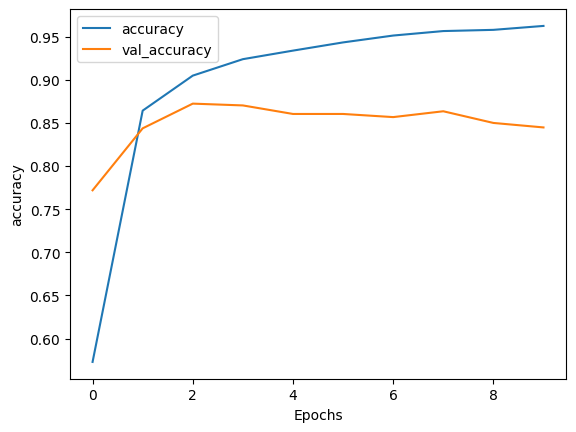

In [21]:
plot_graphs(history, 'accuracy')

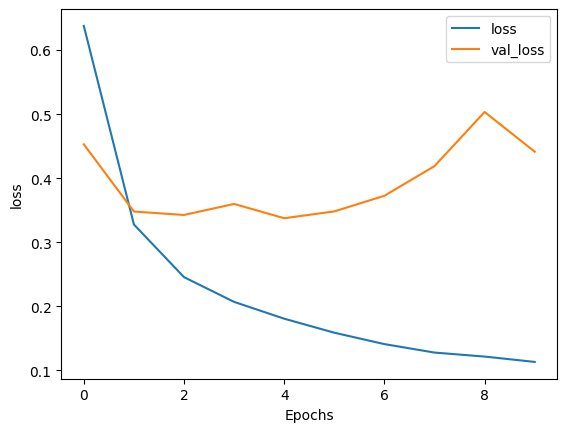

In [22]:
plot_graphs(history, 'loss')

## 2つ以上の LSTM レイヤーを重ねる

Keras のリカレントレイヤーには、コンストラクタの `return_sequences` 引数でコントロールされる2つのモードがあります。

* それぞれのタイムステップの連続した出力のシーケンス全体（shape が `(batch_size, timesteps, output_features)` の3階テンソル）を返す。
* それぞれの入力シーケンスの最後の出力だけ（shape が `(batch_size, output_features)` の2階テンソル）を返す。

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


391/391 [==============================] - 121s 293ms/step - loss: 0.6737 - accuracy: 0.5259 - val_loss: 0.5292 - val_accuracy: 0.7323


Epoch 2/10


391/391 [==============================] - 102s 259ms/step - loss: 0.3894 - accuracy: 0.8358 - val_loss: 0.3543 - val_accuracy: 0.8495


Epoch 3/10


391/391 [==============================] - 93s 236ms/step - loss: 0.2694 - accuracy: 0.9007 - val_loss: 0.3352 - val_accuracy: 0.8552


Epoch 4/10


391/391 [==============================] - 91s 231ms/step - loss: 0.2153 - accuracy: 0.9246 - val_loss: 0.3814 - val_accuracy: 0.8630


Epoch 5/10


391/391 [==============================] - 87s 221ms/step - loss: 0.1838 - accuracy: 0.9384 - val_loss: 0.5294 - val_accuracy: 0.8333


Epoch 6/10


391/391 [==============================] - 84s 213ms/step - loss: 0.1865 - accuracy: 0.9396 - val_loss: 0.3958 - val_accuracy: 0.8661


Epoch 7/10


391/391 [==============================] - 84s 214ms/step - loss: 0.1485 - accuracy: 0.9558 - val_loss: 0.4012 - val_accuracy: 0.8344


Epoch 8/10


391/391 [==============================] - 82s 209ms/step - loss: 0.1339 - accuracy: 0.9594 - val_loss: 0.4415 - val_accuracy: 0.8552


Epoch 9/10


391/391 [==============================] - 82s 209ms/step - loss: 0.1149 - accuracy: 0.9678 - val_loss: 0.4878 - val_accuracy: 0.8578


Epoch 10/10


391/391 [==============================] - 82s 209ms/step - loss: 0.1024 - accuracy: 0.9728 - val_loss: 0.5066 - val_accuracy: 0.8443


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 32s 81ms/step - loss: 0.4923 - accuracy: 0.8470


Test Loss: 0.4922844171524048
Test Accuracy: 0.8470399975776672


In [27]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

1/1 [==============================] - 1s 1s/step


[[-2.682913]]


In [28]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

1/1 [==============================] - 1s 1s/step


[[-3.806074]]


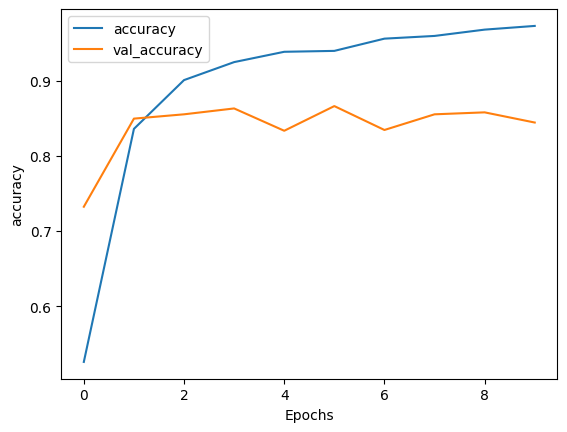

In [29]:
plot_graphs(history, 'accuracy')

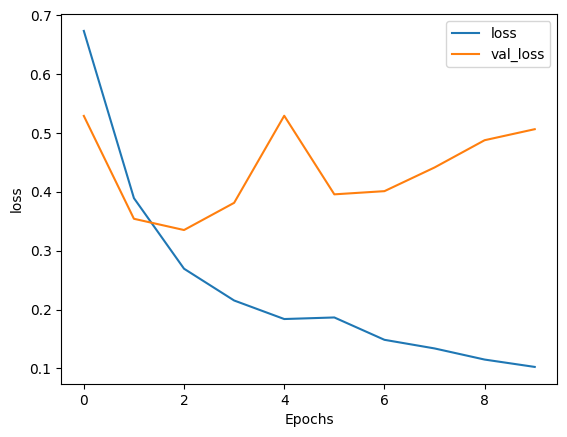

In [30]:
plot_graphs(history, 'loss')

[GRU レイヤー](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)など既存のほかのレイヤーを調べてみましょう。

カスタム RNN の構築に興味があるのであれば、[Keras RNN ガイド](../../guide/keras/rnn.ipynb) を参照してください。